In [2]:
import torch

# torch needs to be specified before otherwise issues with model
import deepsensor.torch
import deepsensor

# from deepsensor.model import ConvNP
from deepsensor.train import Trainer, set_gpu_default_device

# load my own function
from kb_utils import construct_circ_and_linear_time_ds

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from tqdm.notebook import tqdm # updated command to avoid warnings

import logging
logging.captureWarnings(True)

# fdm throughs some errors re np.math

# During developer mode:
# Load the "autoreload" extension so that code can change
# %load_ext autoreload
# Always reload modules so that as you change code in src, it gets loaded
# %autoreload 2

/home/kim/grace_convNP/.conda/lib/python3.11/site-packages/fdm/fdm.py:38: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  coefs = mat.inv()[:, deriv] * np.math.factorial(deriv)
/home/kim/grace_convNP/.conda/lib/python3.11/site-packages/fdm/fdm.py:44: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  / np.math.factorial(order)
/home/kim/grace_convNP/.conda/lib/python3.11/site-packages/fdm/fdm.py:38: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  coefs = mat.inv()[:, deriv] * np.math.factorial(deriv)
/home/kim/grace_convNP/.conda/lib/python3.11/site-packages/fdm/fdm.py:44: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (D

In [3]:
# Define device
print(torch.get_default_device())
deepsensor.train.set_gpu_default_device()
print()
print("Device now:")
print(torch.get_default_device())

# try on cpu to isolate problem
# torch.set_default_device("cpu")
# print(torch.get_default_device())

cpu

Device now:
cuda:0


# Training set-up

Run ablations over different versions and compare conversion. 

## Version 1
Context:
- off-grid gmb
- full-grid landmask
- full-grid temporal encoding (cos, sin, (year)) [Note: year breaks non-stationarity]

Target:
- full gmb

## Version 2

Context:
- off-grid gmb
- full-grid landmask
- full-grid temporal encoding (cos, sin, (year))
- bed topography and surface elevation

Target:
- full gmb

## Version 3

Context:
- off-grid gmb
- full-grid landmask
- full-grid temperature data
- full-grid temporal encoding (cos, sin, (year))
- bed topography and surface elevation

Target:
- full gmb

## Training-validation split

- 168 months (74%) training
- 59 months (26%) validation data

## 

# Load data

In [79]:
# load xarray DataSet
gmb_xds = xr.open_dataset(
    "/home/kim/grace_convNP/data/GRACE_COST-G/GRAVIS-3_2002095-2023334_COSTG_0100_AIS_GRID_TUD_0003.nc")

In [80]:
gmb_xds

<xarray.Dataset>
Dimensions:   (x: 117, y: 97, time: 227)
Coordinates:
  * x         (x) float64 -2.9e+06 -2.85e+06 -2.8e+06 ... 2.85e+06 2.9e+06
  * y         (y) float64 -2.4e+06 -2.35e+06 -2.3e+06 ... 2.35e+06 2.4e+06
  * time      (time) datetime64[ns] 2002-04-18 2002-05-10 ... 2023-11-16
Data variables:
    time_dec  (time) float64 ...
    lon       (y, x) float64 ...
    lat       (y, x) float64 ...
    dm        (time, y, x) float64 ...
    area      (y, x) float64 ...
    crs       |S1 ...
Attributes: (12/16)
    title:                Gridded AIS Mass Changes
    institution:          TU Dresden, Chair of Geodetic Earth System Research
    authors:              Andreas Groh, Martin Horwath, Thorben Döhne
    project:              GravIS GRACE/GRACE-FO Level-3 Products
    source:               Monthly COST-G RL01 GRACE/GRACE-FO Level-2B product...
    summary:              GRACE/GRACE-FO derived time series of gridded Antar...
    ...                   ...
    product_version:      0003
    doi:                  10.5880/COST-G.GRAVIS_01_L3_ICE
    netCDF_version:       netCDF-4_classic
    conventions:          CF-1.6
    date_created:         2024-04-05
    contact:              thorben.doehne@tu-dresden.de

## Generate mask as additional input

In [1]:
from kb_utils import construct_circ_and_linear_time_ds

In [83]:
# Create copy of xarray (data array) dm (delta mass) for mask
# any time slice will do
mask_xda = gmb_xds.dm["time" == '2002-04-18T00:00:00.000000000'].copy()

# rename variable name mask_xda.name
mask_xda = mask_xda.rename("land_mask")

# Remove time as (index: already removed) and as coordinate (unused coordinate)
# mask_xda = mask_xda.drop_indexes('time') # drops it from index
mask_xda = mask_xda.drop_vars('time') # drops it in coordinates
# mask_xda = mask_xda.reset_index(("y", "x"))

# Set to 1 (land) if there are no nan
mask_xda.values[np.isnan(mask_xda.values) == False] = 1
mask_xda.values[np.isnan(mask_xda.values) == True] = 0

mask_xda

<xarray.DataArray 'land_mask' (y: 97, x: 117)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * x        (x) float64 -2.9e+06 -2.85e+06 -2.8e+06 ... 2.85e+06 2.9e+06
  * y        (y) float64 -2.4e+06 -2.35e+06 -2.3e+06 ... 2.35e+06 2.4e+06
Attributes:
    long_name:      change in ice mass
    standard_name:  change_in_land_ice_amount
    units:          kg/m^2
    valid_max:      5002.6
    valid_min:      -8273.7

### Circular day of year + year encoding

In [Deepsensor training](https://alan-turing-institute.github.io/deepsensor/user-guide/training.html), the circualt encoding is just added to the training mask

In [129]:
def construct_circ_and_linear_time_ds(dates, freq):
    """
    Return an :class:`xarray.Dataset` containing a circular variable for time.
    The ``freq`` entry dictates the frequency of cycling of the circular
    variable. E.g.:
    Note: Can be applied after preprocessing since outputs are normalised.

        - ``'H'``: cycles once per day at hourly intervals
        - ``'D'``: cycles once per year at daily intervals
        - ``'M'``: cycles once per year at monthly intervals

    Args:
        dates (...):
            ...
        freq (...):
            ...

    Returns:
        :class:`xarray.Dataset`
            ...
    """
    # Ensure dates are pandas
    dates = pd.DatetimeIndex(dates)
    if freq == "D":
        time_var = dates.dayofyear
        mod = 365.25
    elif freq == "H":
        time_var = dates.hour
        mod = 24
    elif freq == "M":
        time_var = dates.month
        mod = 12
    else:
        raise ValueError("Circular time variable not implemented for this frequency.")

    cos_time = np.cos(2 * np.pi * time_var / mod)
    sin_time = np.sin(2 * np.pi * time_var / mod)
    # normalised year
    year_time = (((dates.year - dates.year.min())/(dates.year.max() - dates.year.min()) * 2) - 1)

    ds = xr.Dataset(
        coords = {"time": dates},
        data_vars = {
            f"cos_{freq}": ("time", cos_time),
            f"sin_{freq}": ("time", sin_time),
            f"year": ("time", year_time),
        },
    )
    return ds

In [130]:
dates = gmb_xds.dm.time.values

# Day-of-year temporal encoding as xarray Dataset
doy_xds = deepsensor.data.construct_circ_time_ds(dates, freq = "D")

# my own function
doy_xds = construct_circ_and_linear_time_ds(dates, freq = "D")
# https://alan-turing-institute.github.io/deepsensor/_modules/deepsensor/data/utils.html#construct_circ_time_ds
# Uses pd.DatetimeIndex(doy_xds["time"]).year

doy_xds

<xarray.Dataset>
Dimensions:  (time: 227)
Coordinates:
  * time     (time) datetime64[ns] 2002-04-18 2002-05-10 ... 2023-11-16
Data variables:
    cos_D    (time) float64 -0.2831 -0.6175 -0.7105 ... -0.2541 0.2562 0.712
    sin_D    (time) float64 0.9591 0.7866 -0.7037 ... -0.9672 -0.9666 -0.7021
    year     (time) float64 -1.0 -1.0 -1.0 -1.0 -1.0 ... 1.0 1.0 1.0 1.0 1.0

In [131]:
fig = go.Figure()

fig.add_trace(go.Scatter(x = np.arange(dates.shape[0]), 
                         y = doy_xds["cos_D"],
                         name = 'cosine',
                         mode = "markers+lines",
                         marker = dict(color = 'green'),
                         line = dict(color = 'green')))

fig.add_trace(go.Scatter(x = np.arange(dates.shape[0]), 
                         y = doy_xds["sin_D"],
                         name = 'sinus',
                         mode = "markers+lines",
                         marker = dict(color = 'red'),
                         line = dict(color = 'red')))

fig.add_trace(go.Scatter(x = np.arange(dates.shape[0]), 
                         y = doy_xds["year"],
                         name = 'year',
                         mode = "markers+lines",
                         marker = dict(color = 'pink'),
                         line = dict(color = 'pink')))

fig.update_layout(title = 'Day-of-year encoding',
                   xaxis_title = 'months',
                   yaxis_title = 'value')

fig.update_layout(template = "plotly_white")
fig.update_layout(font_family = "Lato")

fig.show()

# Preprocess

In [61]:
# Initialise the preprocessor
# order needed to be changed

data_processor = deepsensor.data.DataProcessor(time_name = "time", x1_name = "y", x2_name = "x")
print(data_processor)

DataProcessor with normalisation params:
{'coords': {'time': {'name': 'time'},
            'x1': {'map': None, 'name': 'y'},
            'x2': {'map': None, 'name': 'x'}}}


In [135]:
# naming indicates the proprocessing step applied
gmb_pp = data_processor(gmb_xds.dm, method = "mean_std")
mask_pp = data_processor(mask_xda.to_dataset(), method = "min_max") # [-1, 1]

In [140]:
# Assign after preprocessing
mask_pp["doy_cos_D"] = doy_xds["cos_D"]
mask_pp["doy_sin_D"] = doy_xds["sin_D"]
mask_pp["doy_year"] = doy_xds["year"]

In [141]:
mask_pp

<xarray.Dataset>
Dimensions:    (x2: 117, x1: 97, time: 227)
Coordinates:
  * x2         (x2) float64 0.0 0.008621 0.01724 0.02586 ... 0.9828 0.9914 1.0
  * x1         (x1) float64 0.0 0.008621 0.01724 0.02586 ... 0.8103 0.819 0.8276
  * time       (time) datetime64[ns] 2002-04-18 2002-05-10 ... 2023-11-16
Data variables:
    land_mask  (x1, x2) float64 -1.0 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
    doy_cos_D  (time) float64 -0.2831 -0.6175 -0.7105 ... -0.2541 0.2562 0.712
    doy_sin_D  (time) float64 0.9591 0.7866 -0.7037 ... -0.9672 -0.9666 -0.7021
    doy_year   (time) float64 -1.0 -1.0 -1.0 -1.0 -1.0 ... 1.0 1.0 1.0 1.0 1.0

# Task

Interpolation: At any given point t, how well can we predict the grid of data from some measurement locations.

Aux: bed elevation, surface elevation, year, month in year

In [142]:
task_loader = deepsensor.data.TaskLoader(
    context = [gmb_pp, mask_pp],
    target = [gmb_pp],
    # aux_at_targets = aux_ds,
    # links = [(0, 0)],
)

print(task_loader)

TaskLoader(2 context sets, 1 target sets)
Context variable IDs: (('dm',), ('land_mask', 'doy_cos_D', 'doy_sin_D', 'doy_year'))
Target variable IDs: (('dm',),)


In [10]:
# 11 k grid cells
97*117

11349

In [143]:
# Example task from task loafer
task = task_loader(
    "2002-04-18T00:00:00.000000000", # in ds time
    context_sampling = [0.025, "all"], # 0.01: from 100 points to 11k (grid) # 0.025: from 250 points to 11k (grid)
    target_sampling = "all")

# dictionary of lists
print(task)

time: 2002-04-18 00:00:00
ops: []
X_c: [(2, 283), ((1, 97), (1, 117))]
Y_c: [(1, 283), (4, 97, 117)]
X_t: [((1, 97), (1, 117))]
Y_t: [(1, 97, 117)]



In [155]:
task["X_c"]
# look at context Y's
task["Y_c"][1][3]

array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]], dtype=float32)

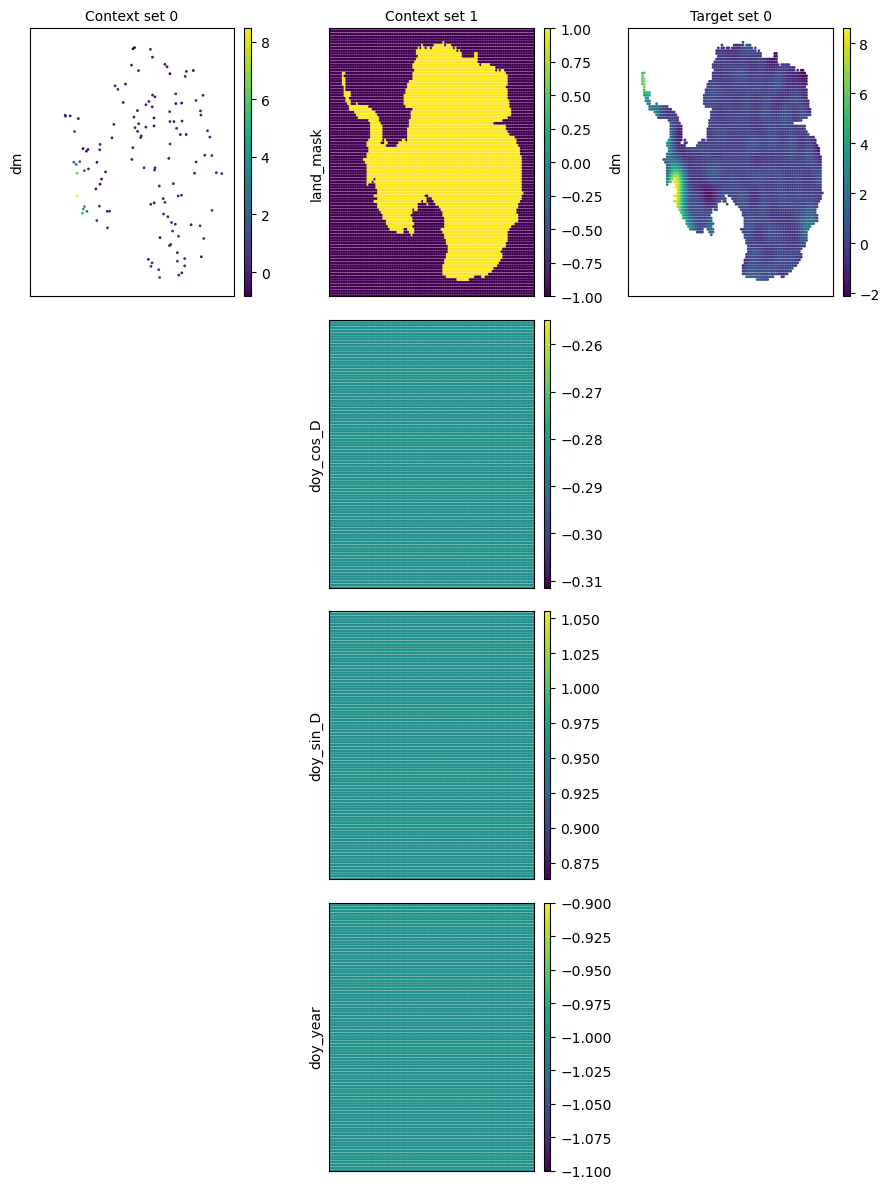

In [156]:
deepsensor.plot.task(task, task_loader)
# vmin and max are not set for vis
plt.show()

time: 2002-04-18 00:00:00
ops: ['target_nans_removed']
X_c: [(2, 283), ((1, 97), (1, 117))]
Y_c: [(1, 283), (4, 97, 117)]
X_t: [(2, 4892)]
Y_t: [(1, 4892)]



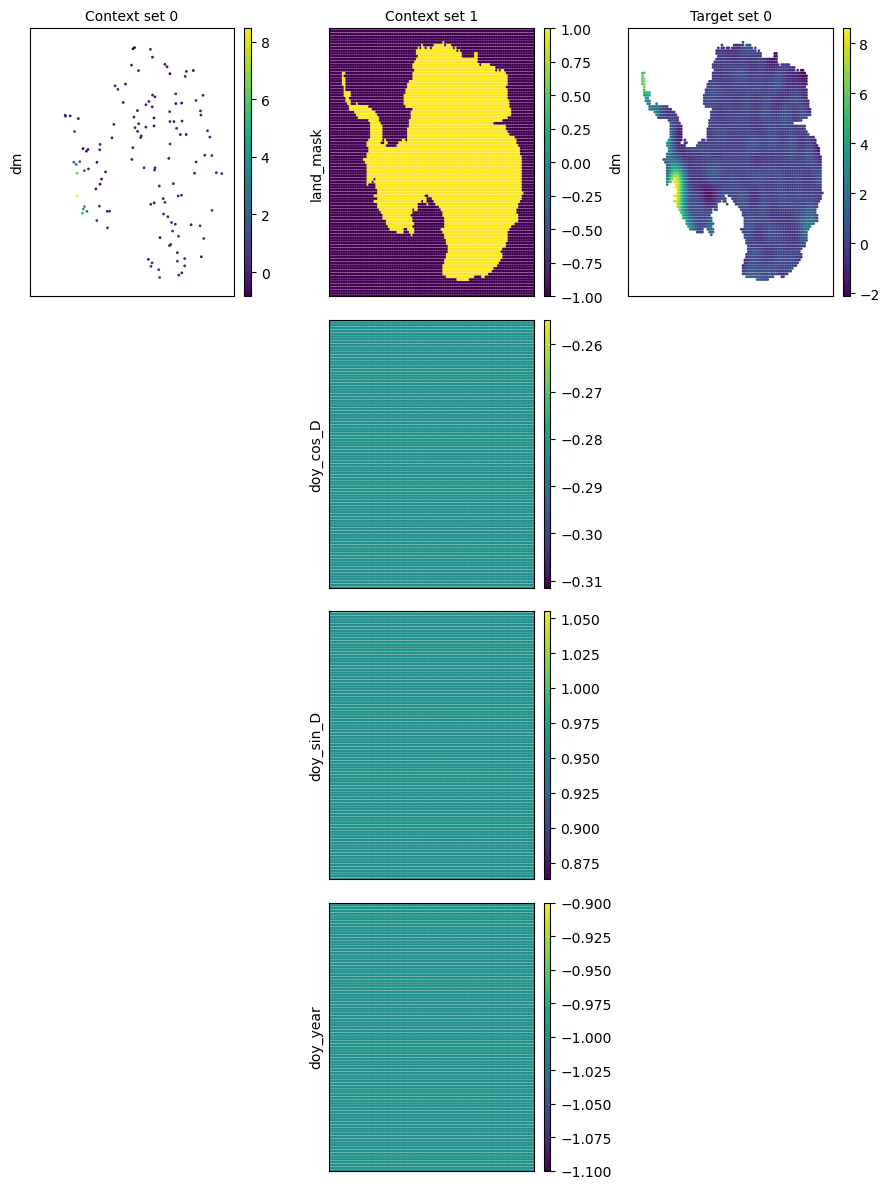

In [157]:
# changes shape of targets as it takes everything away
print(task.remove_target_nans())
deepsensor.plot.task(task.remove_target_nans(), task_loader)
plt.show()

# Model

In [158]:
# model = ConvNP(data_processor, task_loader, internal_density = 500)

# Overwriting the number of unet channels makes it smaller (less params)
model = deepsensor.model.ConvNP(
    data_processor, 
    task_loader, 
    unet_channels = (32, 32, 32, 32, 32))

# Internal density is 116 by default: grid defines our resolution

print(f"Model has {deepsensor.backend.nps.num_params(model.model):,} parameters")

dim_yc inferred from TaskLoader: (1, 4)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 116
encoder_scales inferred from TaskLoader: [0.004310344811528921, 0.004310344811528921]
decoder_scale inferred from TaskLoader: 0.008620689655172414
Model has 338,789 parameters


In [14]:
model = deepsensor.model.ConvNP(
    data_processor, 
    task_loader, 
    # num layers should be uneven (symmetry)
    # unet_channels = (16, 16, 16), # receptive field of only 0.25
    unet_channels = (32, 32, 32, 32, 32),
    internal_density = 116)

print(f"Model has {deepsensor.backend.nps.num_params(model.model):,} parameters")
# Decoder scale is 1/internal density
# encoder scale is independent of internal desnity

dim_yc inferred from TaskLoader: (1, 1)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
encoder_scales inferred from TaskLoader: [0.004310344811528921, 0.004310344811528921]
decoder_scale inferred from TaskLoader: 0.008620689655172414
Model has 336,389 parameters


In [15]:
print(model)

ConvNP with config:
{
    "dim_x": 2,
    "dim_yc": [
        1,
        1
    ],
    "dim_yt": 1,
    "dim_aux_t": 0,
    "dim_lv": 0,
    "conv_arch": "unet",
    "unet_channels": [
        32,
        32,
        32,
        32,
        32
    ],
    "unet_resize_convs": true,
    "unet_resize_conv_interp_method": "bilinear",
    "aux_t_mlp_layers": null,
    "likelihood": "het",
    "unet_kernels": 5,
    "internal_density": 116,
    "encoder_scales": [
        0.004310344811528921,
        0.004310344811528921
    ],
    "encoder_scales_learnable": false,
    "decoder_scale": 0.008620689655172414,
    "decoder_scale_learnable": false,
    "num_basis_functions": 64,
    "epsilon": 0.01
}


## SetConv context encoding

- Density channel for every context set
- output is the concatination of density and data channels
- power of 2

In [159]:
task = task_loader(dates[0], 
                   "all", # one for context
                   "all") # one for target

encoding = deepsensor.model.nps.compute_encoding_tensor(model, task)
print(f"SetConv encoding tensor shape: {encoding.shape}")

# density channel
# encoding[0, 0, :, :]
encoding[0, 1, :, :]

SetConv encoding tensor shape: (1, 7, 128, 160)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

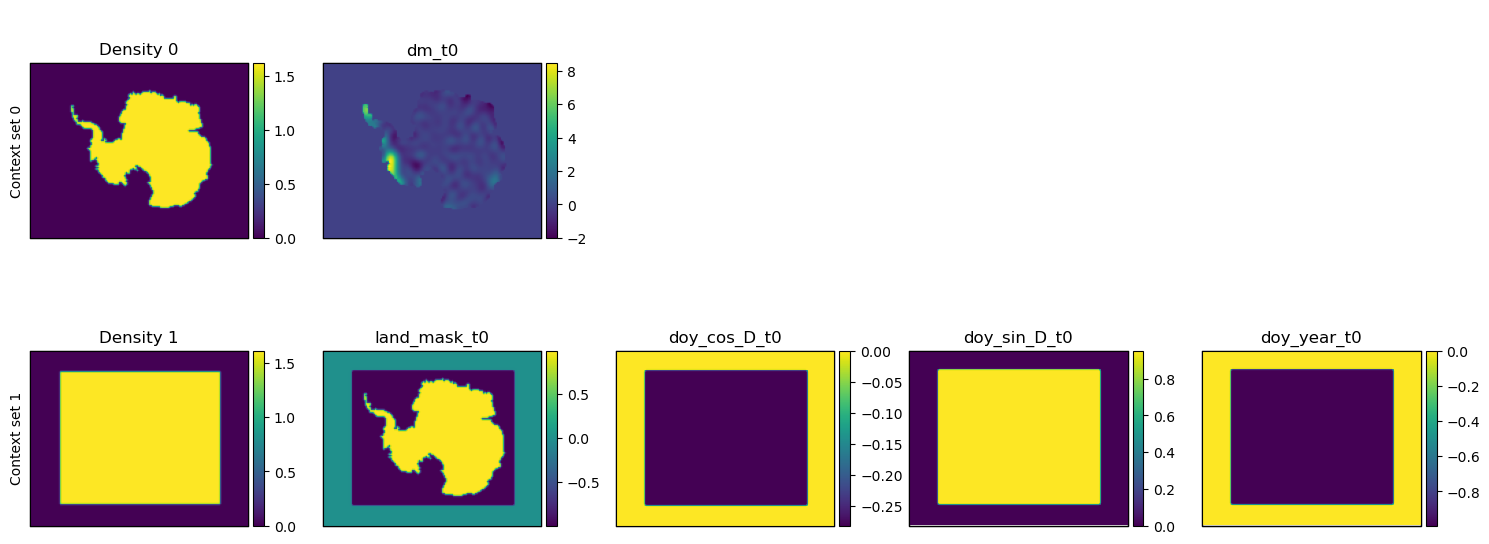

In [160]:
# good for debugging
fig = deepsensor.plot.context_encoding(model, task, task_loader)
plt.show()

In [161]:
# units are different: relative to 1?
model.model.receptive_field

1.1120689655172413

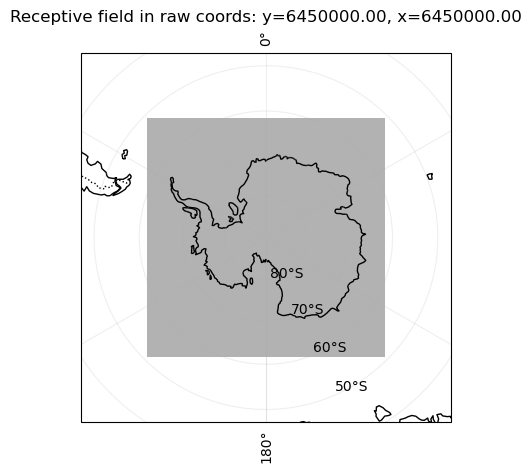

In [162]:
import cartopy.crs as ccrs
import cartopy.feature as cf

fig = deepsensor.plot.receptive_field(
    model.model.receptive_field, 
    data_processor, 
    ccrs.SouthPolarStereo(), 
    # extent = (-3e6, 3e6, -3e6, 3e6)
    extent = (-5e6, 5e6, -5e6, 5e6)) # extent tuple for Antarctica in PolarStereo coords
fig.axes[0].add_feature(cf.BORDERS, linestyle = ':')

plt.show()

# Training

Issue with nan's in targets

In [163]:
all_months = gmb_pp.time.values.astype('datetime64[ns]') # 'datetime64[M]'
print("Number of available months:", all_months.shape)

training_months = all_months[0:168]
validation_months = all_months[168:]

# selects only every xth item from a list through [::x]
date_subsample_factor = 1

Number of available months: (227,)


In [164]:
# helper function
def gen_tasks(months, progress = True):
    # Vary the number of context sets
    tasks = []
    # tqdm update
    for month in tqdm(months, disable = not progress):
        # Vary number of points in context between 5 and 500
        N_c = np.random.randint(5, 500)
        task = task_loader(month, context_sampling = [N_c, "all"], target_sampling = "all")
        # added "remove nans"
        tasks.append(task.remove_target_nans())
    return tasks

In [165]:
val_tasks = gen_tasks(validation_months)

  0%|          | 0/59 [00:00<?, ?it/s]

In [166]:
type(val_tasks)
type(val_tasks[0])
val_tasks[0]["Y_t"]

[array([[-0.3640497 , -0.38748187, -0.4005424 , ...,  1.1617302 ,
          1.189964  ,  1.2612209 ]], dtype=float32)]

In [167]:
def compute_val_rmse(model, val_tasks):
    errors = []
    target_var_ID = task_loader.target_var_IDs[0][0]  # assume 1st target set and 1D
    for task in val_tasks:
        mean = data_processor.map_array(model.mean(task), target_var_ID, unnorm = True)
        true = data_processor.map_array(task["Y_t"][0], target_var_ID, unnorm = True)
        errors.extend(np.abs(mean - true))
    return np.sqrt(np.mean(np.concatenate(errors) ** 2))

In [168]:
deepsensor_folder = "models/deepsensor_config/"

losses = []
val_rmses = []

In [169]:
# Train model
val_rmse_best = np.inf
trainer = Trainer(model, lr = 5e-5)

for epoch in tqdm(range(500)):

    # some missing months so we use a list 
    train_tasks = gen_tasks(training_months[::date_subsample_factor], progress = False)
    # print(len(train_tasks)) # number of training tasks

    # https://github.com/wesselb/lab/blob/master/lab/types.py 332
    # https://github.com/wesselb/neuralprocesses/blob/main/neuralprocesses/model/loglik.py 49 (outputs of the target set)
    batch_losses = trainer(train_tasks)

    losses.append(np.mean(batch_losses))
    val_rmses.append(compute_val_rmse(model, val_tasks))

    if val_rmses[-1] < val_rmse_best:
        val_rmse_best = val_rmses[-1]
        model.save(deepsensor_folder)

  0%|          | 0/500 [00:00<?, ?it/s]

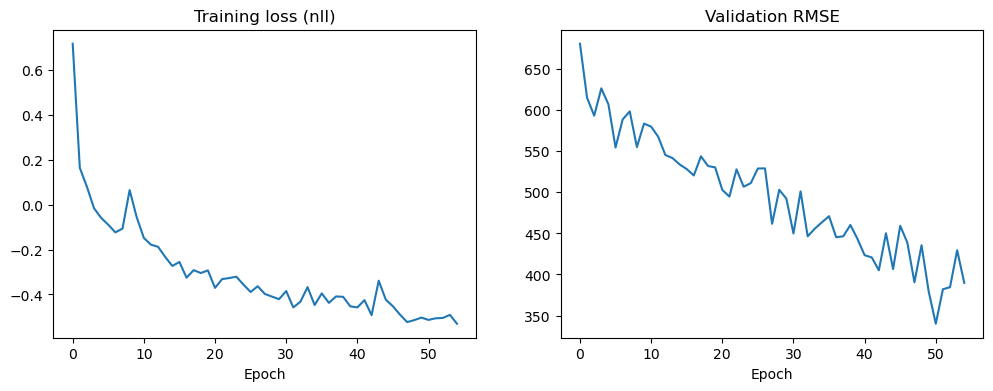

In [39]:
fig, axes = plt.subplots(1, 2, figsize = (12, 4))
axes[0].plot(losses)
axes[1].plot(val_rmses)
_ = axes[0].set_xlabel("Epoch")
_ = axes[1].set_xlabel("Epoch")
_ = axes[0].set_title("Training loss (nll)")
_ = axes[1].set_title("Validation RMSE")

plt.show()

- check mean and std to see if it learned anything meaningful.

# 350 Validation RMSE after 50 epochs

In [47]:
gmb_ds

<xarray.DataArray 'dm' (time: 195, x1: 97, x2: 117)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * x2       (x2) float64 0.0 0.008621 0.01724 0.02586 ... 0.9828 0.9914 1.0
  * x1       (x1) float64 0.0 0.008621 0.01724 0.02586 ... 0.8103 0.819 0.8276
  * time     (time) datetime64[ns] 2002-04-18 2002-05-10 ... 2021-03-16T12:00:00

## Off-grid prediction (because of nan considered off-grid)

In [101]:
from itertools import product
recent_date = dates[-1]
test_task = task_loader(
    recent_date, 
    [200, "all"], 
    "all", 
    seed_override = 42)

# Take locations from any 
# shape (2, 11349)
X_target_np = np.array(list(product(
    list(test_task["X_t"][0][0][-1]), 
    list(test_task["X_t"][0][1][-1])))).T

In [104]:
recent_date = dates[-1]
test_task = task_loader(
    recent_date, 
    [200, "all"], 
    "all", 
    seed_override = 42)

pred = model.predict(
    test_task,
    # X_t = test_task["X_t"][0]
    X_t = X_target_np
    )

In [114]:
fig, ax = plt.subplots(figsize = (5, 5), subplot_kw= {"projection": ccrs.SouthPolarStereo()})
deepsensor.plot.offgrid_context(ax, test_task, data_processor, task_loader)
for i in range(X_target_np.shape[-1]):
    ax.scatter(X_target_np[0, i], X_target_np[1, i], c = "r", s = 5)
ax.coastlines()
ax.set_title("Target locations (red)")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


KeyboardInterrupt: 

In [107]:
fig = deepsensor.plot.prediction(pred, 
                                 recent_date, 
                                 data_processor, 
                                 task_loader, 
                                 test_task, 
                                 crs = ccrs.SouthPolarStereo())

AssertionError: Cannot pass a `date` for off-grid predictions